In [ ]:
!pip install cityscapesscripts

In [ ]:
!wget --keep-session-cookies --save-cookies=cookies.txt --post-data 'username=praneshraj&password=@Budapest27&submit=Login' https://www.cityscapes-dataset.com/login/


--2025-04-29 03:47:10--  https://www.cityscapes-dataset.com/login/
Resolving www.cityscapes-dataset.com (www.cityscapes-dataset.com)... 139.19.217.8
Connecting to www.cityscapes-dataset.com (www.cityscapes-dataset.com)|139.19.217.8|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.cityscapes-dataset.com/downloads/ [following]
--2025-04-29 03:47:10--  https://www.cityscapes-dataset.com/downloads/
Reusing existing connection to www.cityscapes-dataset.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘index.html.1’

index.html.1            [  <=>               ]  55.82K   243KB/s    in 0.2s    

2025-04-29 03:47:11 (243 KB/s) - ‘index.html.1’ saved [57162]



In [ ]:
!wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=1

--2025-04-29 03:47:11--  https://www.cityscapes-dataset.com/file-handling/?packageID=1
Resolving www.cityscapes-dataset.com (www.cityscapes-dataset.com)... 139.19.217.8
Connecting to www.cityscapes-dataset.com (www.cityscapes-dataset.com)|139.19.217.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252567705 (241M) [application/octet-stream]
Saving to: ‘gtFine_trainvaltest.zip.1’

gtFine_trainvaltest 100%[===================>] 240.87M  26.9MB/s    in 9.7s    

2025-04-29 03:47:21 (24.7 MB/s) - ‘gtFine_trainvaltest.zip.1’ saved [252567705/252567705]



In [ ]:
!wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=3

--2025-04-29 03:47:21--  https://www.cityscapes-dataset.com/file-handling/?packageID=3
Resolving www.cityscapes-dataset.com (www.cityscapes-dataset.com)... 139.19.217.8
Connecting to www.cityscapes-dataset.com (www.cityscapes-dataset.com)|139.19.217.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11592327197 (11G) [application/octet-stream]
Saving to: ‘leftImg8bit_trainvaltest.zip’

leftImg8bit_trainva 100%[===================>]  10.80G  14.0MB/s    in 7m 14s  

2025-04-29 03:54:36 (25.5 MB/s) - ‘leftImg8bit_trainvaltest.zip’ saved [11592327197/11592327197]



In [ ]:
import zipfile
import os

# Define paths
left_img_zip = '/content/leftImg8bit_trainvaltest.zip'


gt_fine_zip = '/content/gtFine_trainvaltest.zip.1'

# Unzip the files
def unzip_file(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Extracting left images and annotations
left_img_dir = '/content/leftImg8bit'
gt_fine_dir = '/content/gtFine'

# Unzipping the files
unzip_file(gt_fine_zip, gt_fine_dir)
unzip_file(left_img_zip, left_img_dir)

print("Files unzipped!")


Files unzipped!


In [ ]:
import os
import json
import torch
import numpy as np
import cv2
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset
from matplotlib import pyplot as plt

class CustomCityscapesDetectionDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, split='train', transform=None):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.split = split
        self.transform = transform

        self.image_paths = []
        self.label_paths = []
        self.polygon_paths = []

        self.cities = os.listdir(os.path.join(self.image_dir, self.split))

        for city in self.cities:
            city_image_dir = os.path.join(self.image_dir, self.split, city)
            city_annotation_dir = os.path.join(self.annotation_dir, self.split, city)

            if os.path.isdir(city_image_dir) and os.path.isdir(city_annotation_dir):
                for img_filename in os.listdir(city_image_dir):
                    if img_filename.endswith('_leftImg8bit.png'):
                        img_path = os.path.join(city_image_dir, img_filename)
                        label_filename = img_filename.replace('_leftImg8bit.png', '_gtFine_labelIds.png')
                        polygon_filename = img_filename.replace('_leftImg8bit.png', '_gtFine_polygons.json')

                        label_path = os.path.join(city_annotation_dir, label_filename)
                        polygon_path = os.path.join(city_annotation_dir, polygon_filename)

                        if os.path.exists(label_path) and os.path.exists(polygon_path):
                            self.image_paths.append(img_path)
                            self.label_paths.append(label_path)
                            self.polygon_paths.append(polygon_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label_path = self.label_paths[idx]
        polygon_path = self.polygon_paths[idx]

        image = Image.open(img_path).convert('RGB')
        segmentation_mask = Image.open(label_path)

        with open(polygon_path, 'r') as f:
            polygon_data = json.load(f)

        width, height = segmentation_mask.size
        boundary_mask = np.zeros((height, width), dtype=np.uint8)

        boxes = []
        labels = []
        for obj in polygon_data['objects']:
            polygon = np.array(obj['polygon'], dtype=np.int32)
            cv2.polylines(boundary_mask, [polygon], isClosed=True, color=255, thickness=2)

            x_coords = polygon[:, 0]
            y_coords = polygon[:, 1]
            x_min, y_min = np.min(x_coords), np.min(y_coords)
            x_max, y_max = np.max(x_coords), np.max(y_coords)
            boxes.append([x_min, y_min, x_max, y_max])
            labels.append(1)  # Default class

        boundary_mask = Image.fromarray(boundary_mask)

        if self.transform:
            image = self.transform(image)

        segmentation_mask = torch.tensor(np.array(segmentation_mask), dtype=torch.long)
        boundary_mask = torch.tensor(np.array(boundary_mask), dtype=torch.uint8)

        target = {
            'boxes': torch.tensor(boxes, dtype=torch.float32),
            'labels': torch.tensor(labels, dtype=torch.int64),
            'image_id': torch.tensor([idx])
        }

        return image, segmentation_mask, boundary_mask, target


# Define dataset parameters
image_dir = '/content/leftImg8bit/leftImg8bit'
annotation_dir = '/content/gtFine/gtFine'

# Define transformations with preprocessing steps
transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jitter
    transforms.ToTensor(),
])


# Create dataset instance
dataset = CustomCityscapesDetectionDataset(image_dir, annotation_dir, split='train', transform=transform)

# Debug: Check dataset size
print(f"Dataset Length: {len(dataset)}")

# Example: Fetch one sample
if len(dataset) > 0:
    image, segmentation_mask, boundary_mask,target = dataset[0]
    print(f"Image Shape: {image.shape}")  # CxHxW
    print(f"Segmentation Mask Shape: {segmentation_mask.shape}")  # HxW
    print(f"Boundary Mask Shape: {boundary_mask.shape}")  # HxW
else:
    print("Dataset is empty.")


Dataset Length: 2975
Image Shape: torch.Size([3, 1024, 2048])
Segmentation Mask Shape: torch.Size([1024, 2048])
Boundary Mask Shape: torch.Size([1024, 2048])


In [ ]:
import os
import json
import torch
import numpy as np
import cv2
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

In [ ]:
# Define a strong augmentation pipeline for training images and masks
def get_training_augmentation():
    return A.Compose([
        # A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.02),
        A.GaussianBlur(blur_limit=(3, 7), p=0.01),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.03),
        A.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

# Validation/test transforms (no augmentation)
def get_validation_augmentation():
    return A.Compose([
        A.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

def center_crop(img_tensor, crop_height, crop_width):
    _, h, w = img_tensor.shape if img_tensor.ndim == 3 else (1, *img_tensor.shape)
    top = (h - crop_height) // 2
    left = (w - crop_width) // 2
    return img_tensor[..., top:top+crop_height, left:left+crop_width]

def save_preprocessed_data(dataset, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    img_dir = os.path.join(save_dir, 'images')
    mask_dir = os.path.join(save_dir, 'masks')
    boundary_dir = os.path.join(save_dir, 'boundaries')
    os.makedirs(img_dir, exist_ok=True)
    os.makedirs(mask_dir, exist_ok=True)
    os.makedirs(boundary_dir, exist_ok=True)

    for idx in tqdm(range(len(dataset)), desc="Saving Preprocessed Data"):
        image, segmentation_mask, boundary_mask, _ = dataset[idx]

        image_np = (image.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        mask_np = segmentation_mask.numpy().astype(np.uint8)
        boundary_np = boundary_mask.numpy().astype(np.uint8)

        Image.fromarray(image_np).save(os.path.join(img_dir, f'image_{idx:05d}.png'))
        Image.fromarray(mask_np).save(os.path.join(mask_dir, f'mask_{idx:05d}.png'))
        Image.fromarray(boundary_np).save(os.path.join(boundary_dir, f'boundary_{idx:05d}.png'))

    print(f"Saved {len(dataset)} preprocessed samples to '{save_dir}'")

class CustomCityscapesDetectionDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, split='train', transform=None):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.split = split
        self.transform = transform

        self.image_paths = []
        self.label_paths = []
        self.polygon_paths = []

        self.cities = os.listdir(os.path.join(self.image_dir, self.split))

        for city in self.cities:
            city_image_dir = os.path.join(self.image_dir, self.split, city)
            city_annotation_dir = os.path.join(self.annotation_dir, self.split, city)

            if os.path.isdir(city_image_dir) and os.path.isdir(city_annotation_dir):
                for img_filename in os.listdir(city_image_dir):
                    if img_filename.endswith('_leftImg8bit.png'):
                        img_path = os.path.join(city_image_dir, img_filename)
                        label_filename = img_filename.replace('_leftImg8bit.png', '_gtFine_labelIds.png')
                        polygon_filename = img_filename.replace('_leftImg8bit.png', '_gtFine_polygons.json')

                        label_path = os.path.join(city_annotation_dir, label_filename)
                        polygon_path = os.path.join(city_annotation_dir, polygon_filename)

                        if os.path.exists(label_path) and os.path.exists(polygon_path):
                            self.image_paths.append(img_path)
                            self.label_paths.append(label_path)
                            self.polygon_paths.append(polygon_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label_path = self.label_paths[idx]
        polygon_path = self.polygon_paths[idx]

        image = Image.open(img_path).convert('RGB')
        segmentation_mask = Image.open(label_path)

        with open(polygon_path, 'r') as f:
            polygon_data = json.load(f)

        width, height = segmentation_mask.size
        boundary_mask = np.zeros((height, width), dtype=np.uint8)

        boxes = []
        labels = []
        for obj in polygon_data['objects']:
            polygon = np.array(obj['polygon'], dtype=np.int32)
            cv2.polylines(boundary_mask, [polygon], isClosed=True, color=255, thickness=2)

            x_coords = polygon[:, 0]
            y_coords = polygon[:, 1]
            x_min, y_min = np.min(x_coords), np.min(y_coords)
            x_max, y_max = np.max(x_coords), np.max(y_coords)
            boxes.append([x_min, y_min, x_max, y_max])
            labels.append(1)  # Default class

        image = transforms.ToTensor()(image) if self.transform is None else self.transform(image)
        segmentation_mask = torch.tensor(np.array(segmentation_mask), dtype=torch.long)
        boundary_mask = torch.tensor(boundary_mask, dtype=torch.uint8)

        crop_height, crop_width = 256, 256
        image = center_crop(image, crop_height, crop_width)
        segmentation_mask = center_crop(segmentation_mask, crop_height, crop_width)
        boundary_mask = center_crop(boundary_mask, crop_height, crop_width)

        target = {
            'boxes': torch.tensor(boxes, dtype=torch.float32),
            'labels': torch.tensor(labels, dtype=torch.int64),
            'image_id': torch.tensor([idx])
        }

        return image, segmentation_mask, boundary_mask, target

In [ ]:
# Define dataset parameters
image_dir = '/content/leftImg8bit/leftImg8bit'
annotation_dir = '/content/gtFine/gtFine'

# Define transformations with preprocessing steps
transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
])

# Create dataset instance
dataset = CustomCityscapesDetectionDataset(image_dir, annotation_dir, split='train', transform=transform)

# Save all preprocessed data
save_preprocessed_data(dataset, '/content/preprocessed_cityscapes')

Saving Preprocessed Data: 100%|██████████| 2975/2975 [21:55<00:00,  2.26it/s]

Saved 2975 preprocessed samples to '/content/preprocessed_cityscapes'


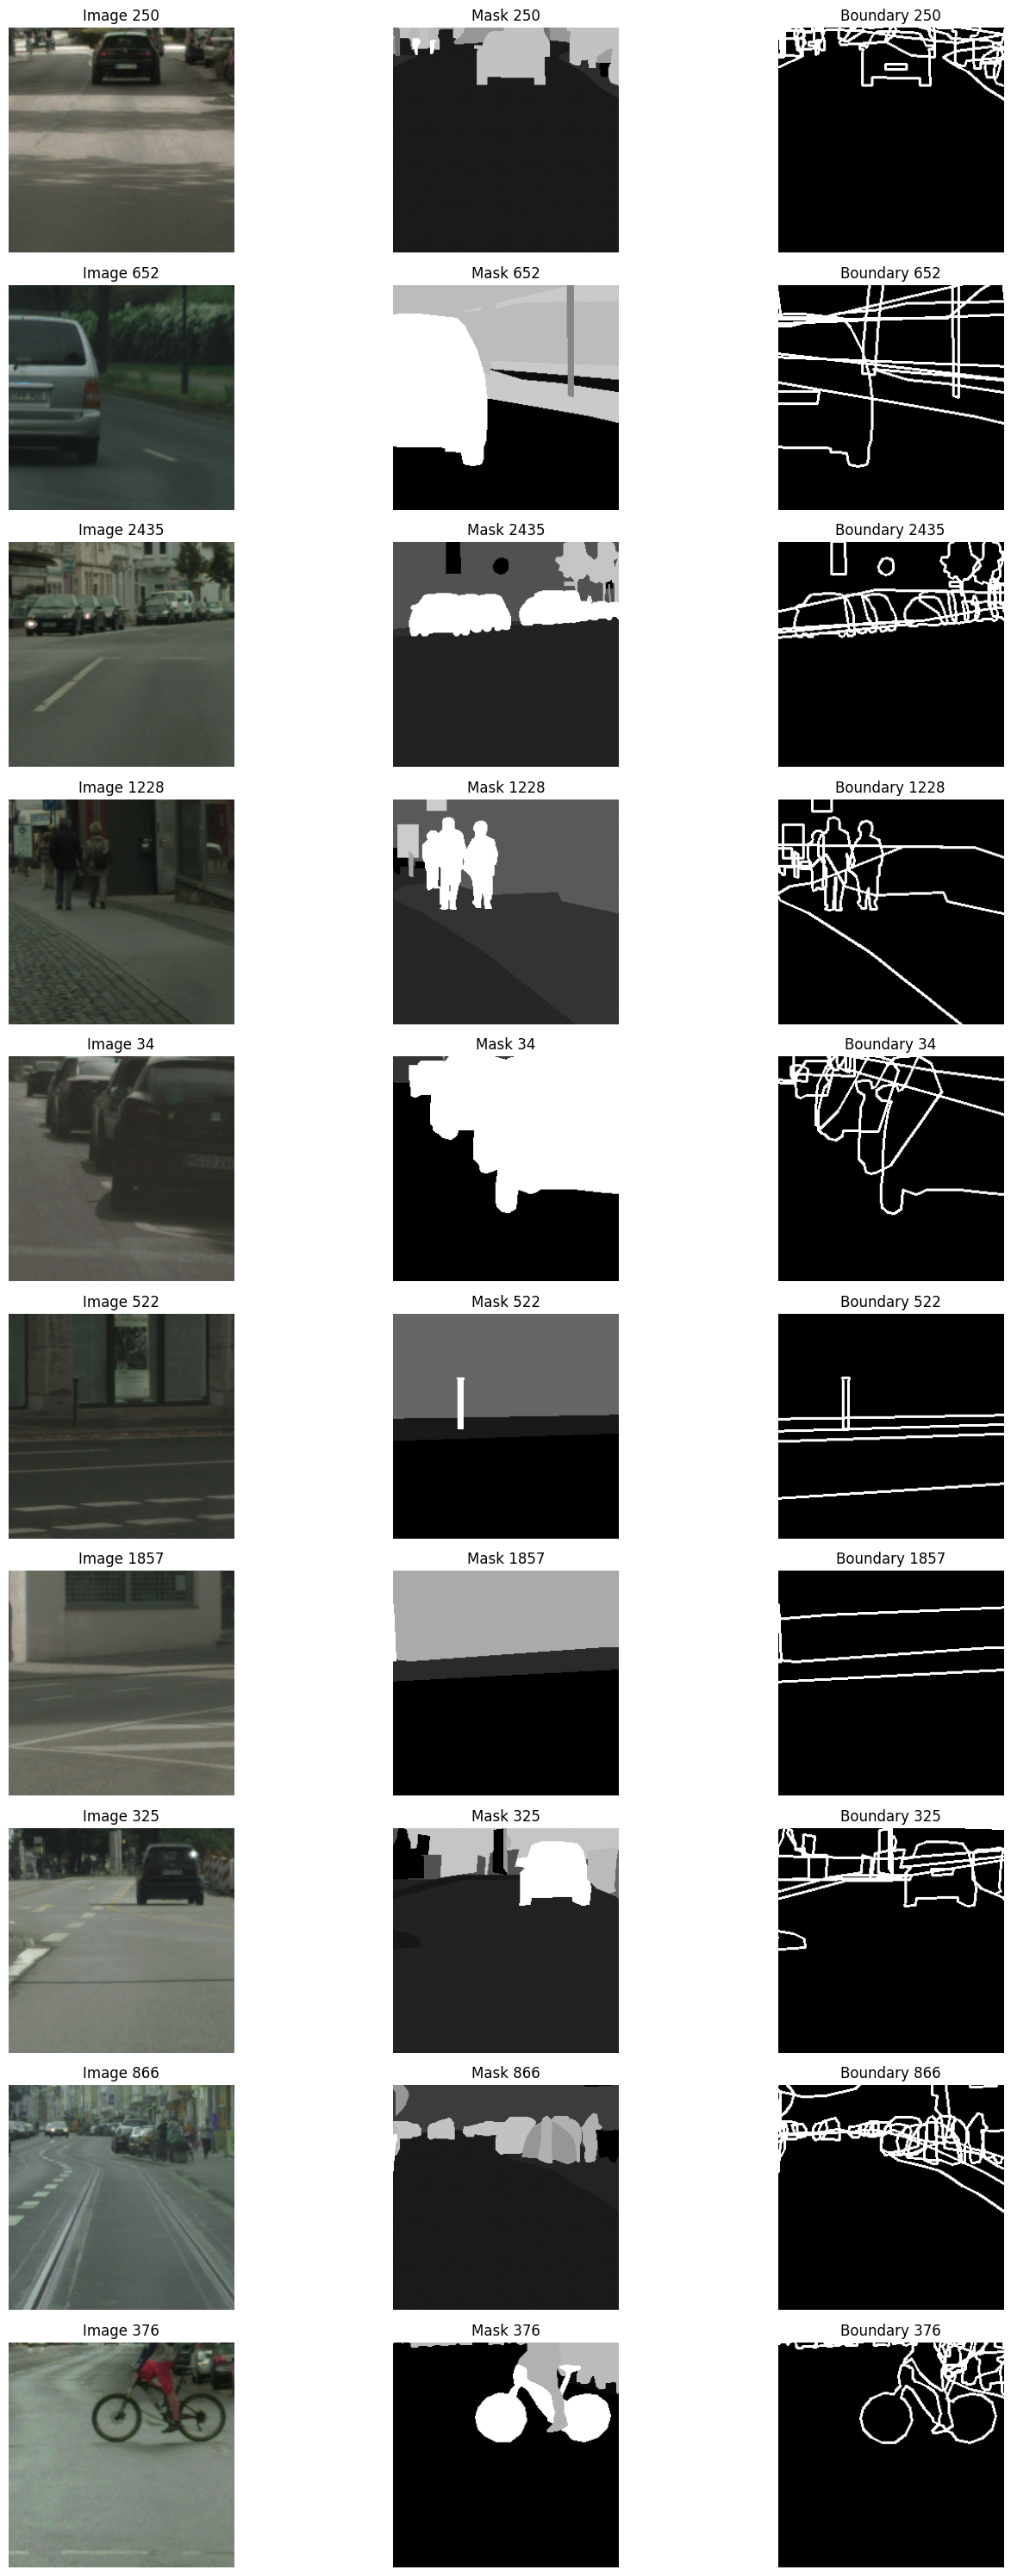

In [ ]:
import random
from glob import glob

# New Visualization Code for Preprocessed Data
def visualize_random_samples(preprocessed_dir, num_samples=10):
    img_dir = os.path.join(preprocessed_dir, 'images')
    mask_dir = os.path.join(preprocessed_dir, 'masks')
    boundary_dir = os.path.join(preprocessed_dir, 'boundaries')

    image_paths = sorted(glob(os.path.join(img_dir, '*.png')))
    mask_paths = sorted(glob(os.path.join(mask_dir, '*.png')))
    boundary_paths = sorted(glob(os.path.join(boundary_dir, '*.png')))

    indices = random.sample(range(len(image_paths)), num_samples)

    plt.figure(figsize=(15, num_samples * 3))

    for i, idx in enumerate(indices):
        image = np.array(Image.open(image_paths[idx]))
        mask = np.array(Image.open(mask_paths[idx]))
        boundary = np.array(Image.open(boundary_paths[idx]))

        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(image)
        plt.title(f'Image {idx}')
        plt.axis('off')

        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(mask, cmap='gray')
        plt.title(f'Mask {idx}')
        plt.axis('off')

        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(boundary, cmap='gray')
        plt.title(f'Boundary {idx}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Usage:
preprocessed_dir = '/content/preprocessed_cityscapes'
visualize_random_samples(preprocessed_dir, num_samples=10)

In [ ]:
import shutil

# Path to the directory
folder_path = '/content/preprocessed_cityscapes'

# Path to save the zip file
zip_path = '/content/preprocessed_cityscapes.zip'

# Compress the folder into a zip file
shutil.make_archive(zip_path.replace('.zip', ''), 'zip', folder_path)


from google.colab import files

# Download the zip file
files.download(zip_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
dataset

In [10]:
import os
import zipfile
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import json
from collections import defaultdict
from glob import glob
import cv2  # For boundary analysis
from google.colab import drive  # For Google Drive interaction
from tqdm import tqdm  # For progress bars



In [11]:
### Data Preparation


# Mount Google Drive (if running in Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    # !! Adjust this path to your zip file in Google Drive !!
    zip_path = '/content/drive/MyDrive/Colab Notebooks/Sem_2_lab/preprocessed_cityscapes.zip'
except ModuleNotFoundError:
    print("Not running in Colab or Drive not available. Assuming data is local.")
    # !! Set this path if running locally !!
    zip_path = 'preprocessed_cityscapes.zip'

extract_path = '/content/preprocessed_cityscapes' if 'google.colab' in str(get_ipython()) else 'preprocessed_cityscapes'
os.makedirs(extract_path, exist_ok=True)

# Extract the dataset
if os.path.exists(zip_path):
    print(f"Extracting {zip_path} to {extract_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction complete.")
else:
    print(f"Error: Zip file not found at {zip_path}. Please check the path.")

# Define data directories
image_dir = os.path.join(extract_path, 'images')
boundary_mask_dir = os.path.join(extract_path, 'boundaries')
full_mask_dir = os.path.join(extract_path, 'masks') # For Faster R-CNN

# Verify directories
if not os.path.isdir(image_dir) or not os.path.isdir(boundary_mask_dir) or not os.path.isdir(full_mask_dir):
    print("Error: Data directories not found after extraction.")
else:
    print("Data directories verified.")
    print(f"Found {len(os.listdir(image_dir))} images.")
    print(f"Found {len(os.listdir(boundary_mask_dir))} boundary masks.")
    print(f"Found {len(os.listdir(full_mask_dir))} full masks.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extracting /content/drive/MyDrive/Colab Notebooks/Sem_2_lab/preprocessed_cityscapes.zip to /content/preprocessed_cityscapes...
Extraction complete.
Data directories verified.
Found 2975 images.
Found 2975 boundary masks.
Found 2975 full masks.


Intensity Analysis: 100%|██████████| 100/100 [00:00<00:00, 200.67it/s]


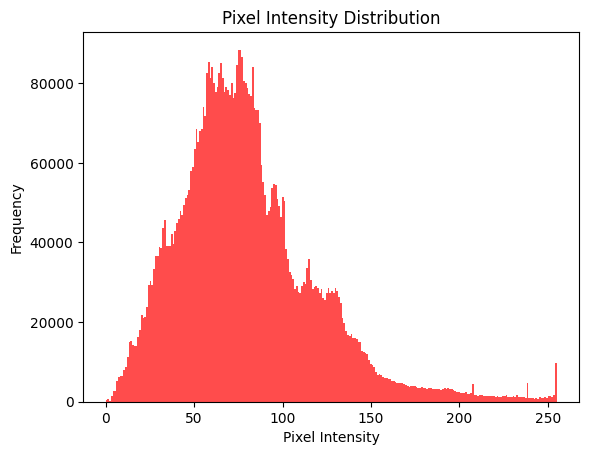

Frequency Analysis: 100%|██████████| 10/10 [00:00<00:00, 32.42it/s]


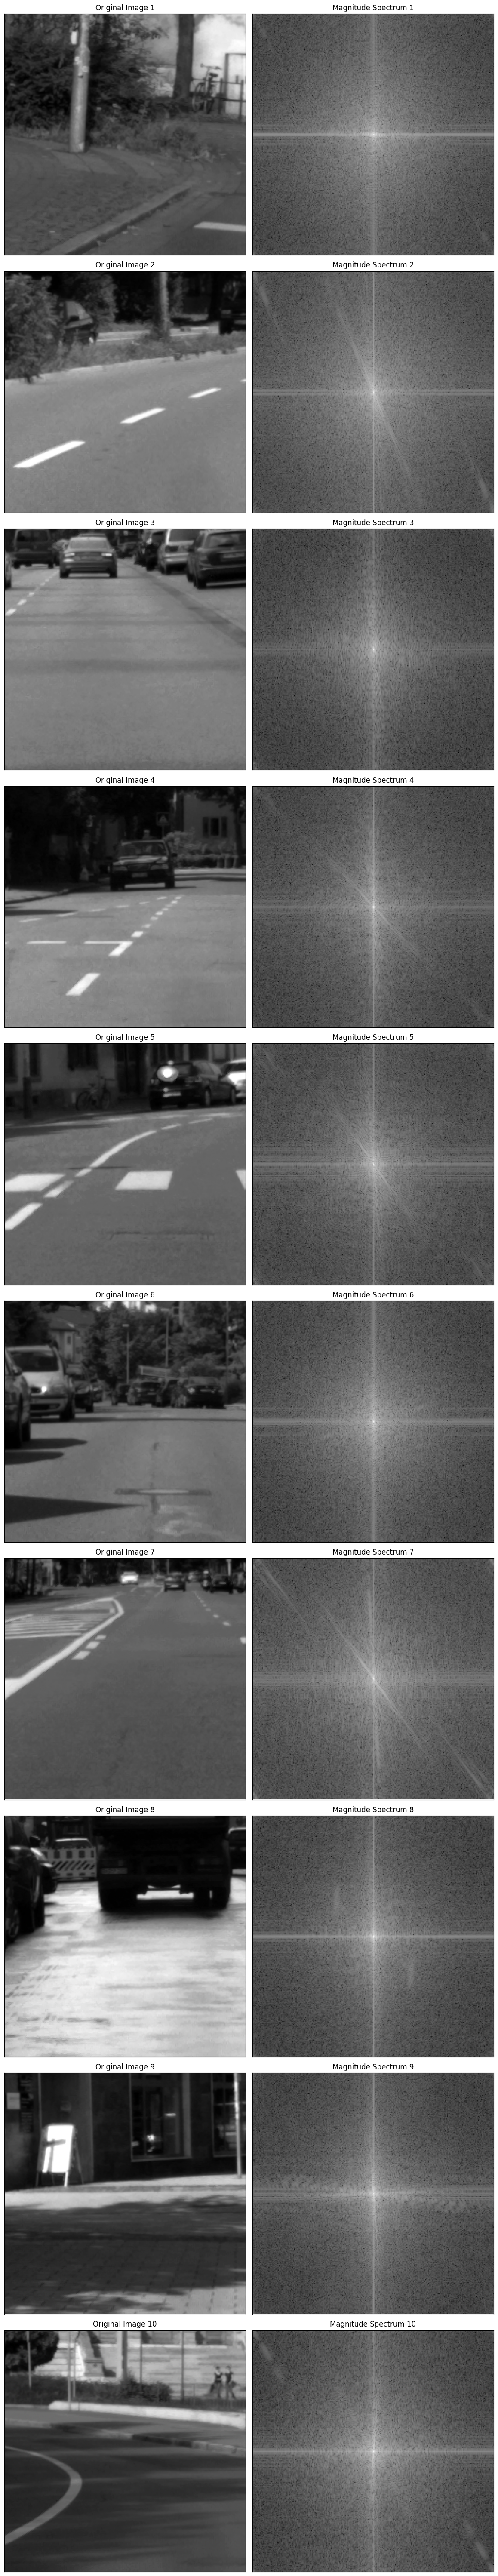

Boundary Complexity: 100%|██████████| 2975/2975 [00:19<00:00, 149.57it/s]


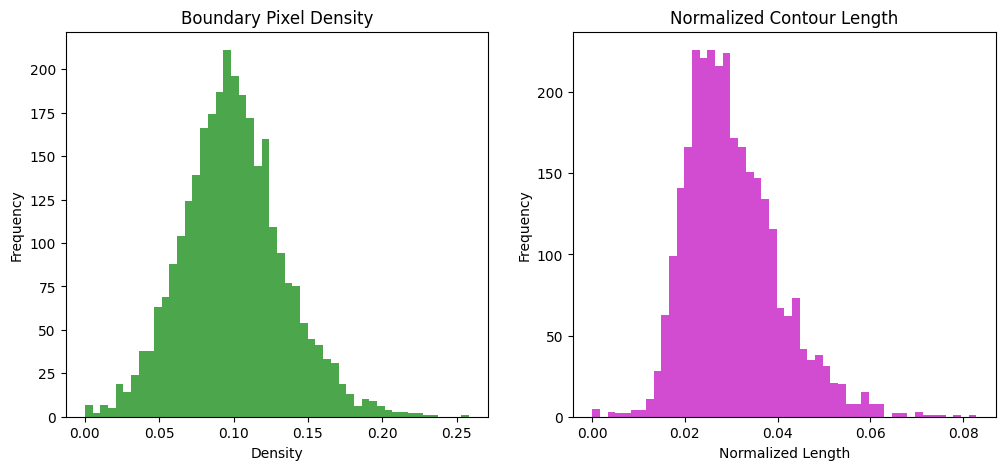

Edge Strength: 100%|██████████| 100/100 [00:01<00:00, 86.17it/s]


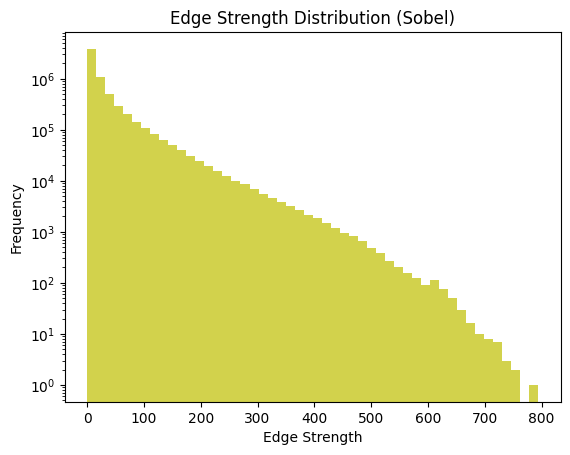

In [13]:
# --- 2. Advanced Analytics (Optimized for PNG-only) ---

# I. Core Image Analysis

# 1. Pixel Intensity Analysis
def analyze_intensity_distribution(image_dir, num_samples=100):
    """Analyzes and visualizes pixel intensity distribution."""

    image_paths = sorted(glob(os.path.join(image_dir, '*.png')))  # Explicitly PNG
    intensities = []
    sample_paths = np.random.choice(
        image_paths, size=min(num_samples, len(image_paths)), replace=False)

    for img_path in tqdm(sample_paths, desc="Intensity Analysis"):
        img = np.array(Image.open(img_path).convert('L'))  # Grayscale
        intensities.extend(img.flatten().tolist())

    plt.hist(intensities, bins=256, color='r', alpha=0.7)
    plt.title('Pixel Intensity Distribution')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()

analyze_intensity_distribution(image_dir)

# 2. Frequency Domain Analysis
def analyze_frequency_domain(image_dir, num_samples=10):
    """Analyzes the frequency domain of images using Fourier Transform."""

    image_paths = sorted(glob(os.path.join(image_dir, '*.png')))  # Explicitly PNG
    sample_paths = np.random.choice(
        image_paths, size=min(num_samples, len(image_paths)), replace=False)

    plt.figure(figsize=(12, 6 * num_samples))

    for i, img_path in enumerate(tqdm(sample_paths, desc="Frequency Analysis")):
        img = np.array(Image.open(img_path).convert('L'))
        f_transform = np.fft.fft2(img)
        f_shift = np.fft.fftshift(f_transform)
        magnitude_spectrum = np.log(np.abs(f_shift) + 1)

        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'Original Image {i + 1}')
        plt.xticks([])
        plt.yticks([])

        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(magnitude_spectrum, cmap='gray')
        plt.title(f'Magnitude Spectrum {i + 1}')
        plt.xticks([])
        plt.yticks([])

    plt.tight_layout()
    plt.show()

analyze_frequency_domain(image_dir)

# II. Edge-Focused Analysis

# 3. Boundary Complexity Analysis
def analyze_boundary_complexity(image_dir, boundary_dir):
    """Analyzes boundary pixel density and contour complexity."""

    image_paths = sorted(glob(os.path.join(image_dir, '*.png')))  # Explicitly PNG
    boundary_paths = sorted(glob(os.path.join(boundary_dir, '*.png')))  # Explicitly PNG

    densities = []
    complexities = []

    for img_path, boundary_path in tqdm(
            zip(image_paths, boundary_paths),
            desc="Boundary Complexity",
            total=len(image_paths)):
        image = np.array(Image.open(img_path))
        boundary = np.array(Image.open(boundary_path))

        total_pixels = image.shape[0] * image.shape[1]
        boundary_pixels = np.count_nonzero(boundary)
        density = boundary_pixels / total_pixels if total_pixels > 0 else 0
        densities.append(density)

        contours, _ = cv2.findContours(
            boundary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        total_contour_length = sum(
            cv2.arcLength(contour, True) for contour in contours)
        normalized_contour_length = total_contour_length / total_pixels if total_pixels > 0 else 0
        complexities.append(normalized_contour_length)

    # Plotting
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(densities, bins=50, color='g', alpha=0.7)
    plt.title('Boundary Pixel Density')
    plt.xlabel('Density')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(complexities, bins=50, color='m', alpha=0.7)
    plt.title('Normalized Contour Length')
    plt.xlabel('Normalized Length')
    plt.ylabel('Frequency')

    plt.show()

analyze_boundary_complexity(image_dir, boundary_dir)

# 4. Edge Strength Distribution
def analyze_edge_strength(image_dir, num_samples=100):
    """Analyzes edge strength distribution using the Sobel operator."""

    image_paths = sorted(glob(os.path.join(image_dir, '*.png')))  # Explicitly PNG
    edge_strengths = []
    sample_paths = np.random.choice(
        image_paths, size=min(num_samples, len(image_paths)), replace=False)

    for img_path in tqdm(sample_paths, desc="Edge Strength"):
        image = np.array(Image.open(img_path).convert('L'))
        sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
        edge_strength = np.sqrt(sobel_x**2 + sobel_y**2)
        edge_strengths.extend(edge_strength.flatten().tolist())

    plt.hist(edge_strengths, bins=50, color='y', alpha=0.7)
    plt.title('Edge Strength Distribution (Sobel)')
    plt.xlabel('Edge Strength')
    plt.ylabel('Frequency')
    plt.yscale('log')
    plt.show()

analyze_edge_strength(image_dir)




Object Dimensions: 100%|██████████| 2975/2975 [00:16<00:00, 181.43it/s]


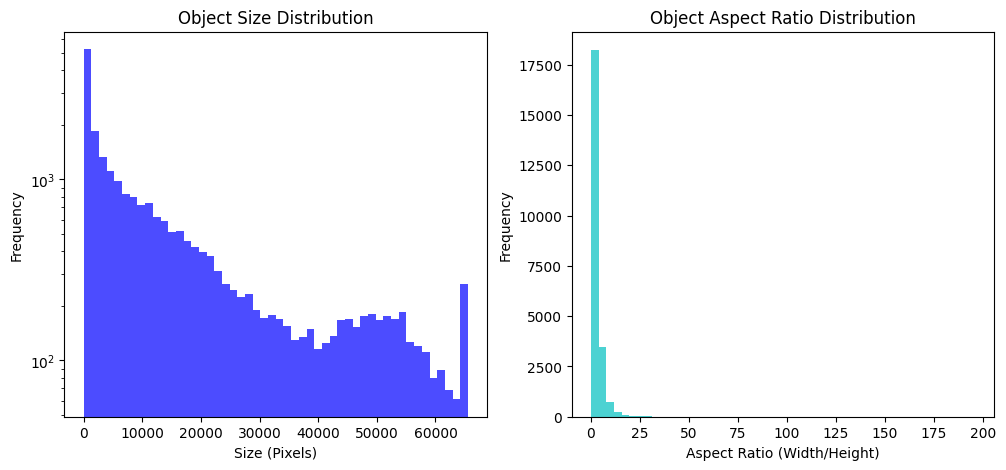

In [15]:
def analyze_object_dimensions(mask_dir):
    """Analyzes object size and aspect ratio."""

    mask_paths = sorted(glob(os.path.join(mask_dir, '*.png')))  # Explicitly PNG
    sizes = []
    aspect_ratios = []

    for mask_path in tqdm(mask_paths, desc="Object Dimensions"):
        mask = np.array(Image.open(mask_path))
        for label in np.unique(mask):
            if label == 0:  # Skip background
                continue
            y_coords, x_coords = np.where(mask == label)
            if len(y_coords) > 0 and len(x_coords) > 0:
                min_x = np.min(x_coords)
                max_x = np.max(x_coords)
                min_y = np.min(y_coords)
                max_y = np.max(y_coords)
                width = max_x - min_x + 1
                height = max_y - min_y + 1
                sizes.append(width * height)
                if height > 0:
                    aspect_ratios.append(width / height)

    # Plotting
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(sizes, bins=50, color='b', alpha=0.7)
    plt.title('Object Size Distribution')
    plt.xlabel('Size (Pixels)')
    plt.ylabel('Frequency')
    plt.yscale('log')

    plt.subplot(1, 2, 2)
    plt.hist(aspect_ratios, bins=50, color='c', alpha=0.7)
    plt.title('Object Aspect Ratio Distribution')
    plt.xlabel('Aspect Ratio (Width/Height)')
    plt.ylabel('Frequency')

    plt.show()

analyze_object_dimensions(full_mask_dir)

In [18]:
# III. Object-Focused Analysis

# 5. Analyze object dimensions
def analyze_object_dimensions(mask_dir):
    """Analyzes object size and aspect ratio."""

    mask_paths = sorted(glob(os.path.join(mask_dir, '*.png')))  # Explicitly PNG
    sizes = []
    aspect_ratios = []

    for mask_path in tqdm(mask_paths, desc="Object Dimensions"):
        mask = np.array(Image.open(mask_path))
        for label in np.unique(mask):
            if label == 0:  # Skip background
                continue
            y_coords, x_coords = np.where(mask == label)
            if len(y_coords) > 0 and len(x_coords) > 0:
                min_x, max_x = np.min(x_coords), np.max(x_coords)
                min_y, max_y = np.min(y_coords)
                width = max_x - min_x + 1
                height = max_y - min_y + 1
                sizes.append(width * height)
                if height > 0:
                    aspect_ratios.append(width / height)

    # Plotting
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(sizes, bins=50, color='b', alpha=0.7)
    plt.title('Object Size Distribution')
    plt.xlabel('Size (Pixels)')
    plt.ylabel('Frequency')
    plt.yscale('log')

    plt.subplot(1, 2, 2)
    plt.hist(aspect_ratios, bins=50, color='c', alpha=0.7)
    plt.title('Object Aspect Ratio Distribution')
    plt.xlabel('Aspect Ratio (Width/Height)')
    plt.ylabel('Frequency')

    plt.show()

analyze_object_dimensions(full_mask_dir)

Object Dimensions:   0%|          | 0/2975 [00:00<?, ?it/s]


TypeError: cannot unpack non-iterable numpy.int64 object

Class Distribution: 100%|██████████| 2975/2975 [00:05<00:00, 537.38it/s]


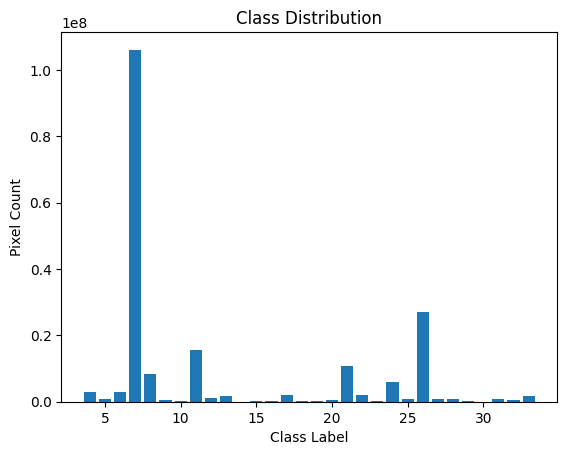

In [16]:




# 6. Class Distribution (if applicable)
def analyze_class_distribution(mask_dir):
    """Analyzes the distribution of object classes in masks."""

    mask_paths = sorted(glob(os.path.join(mask_dir, '*.png')))  # Explicitly PNG
    class_counts = {}

    for mask_path in tqdm(mask_paths, desc="Class Distribution"):
        mask = np.array(Image.open(mask_path))
        unique_labels, counts = np.unique(mask, return_counts=True)
        for label, count in zip(unique_labels, counts):
            if label != 0:  # Skip background
                if label not in class_counts:
                    class_counts[label] = 0
                class_counts[label] += count

    plt.bar(class_counts.keys(), class_counts.values())
    plt.title('Class Distribution')
    plt.xlabel('Class Label')
    plt.ylabel('Pixel Count')
    plt.show()

analyze_class_distribution(full_mask_dir)



Class Co-occurrence: 100%|██████████| 2975/2975 [00:04<00:00, 652.79it/s]


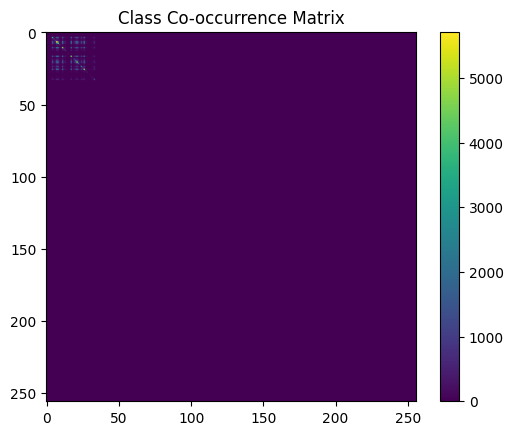

In [19]:
# 7. Object Context Analysis (Example: Simple Co-occurrence)
def analyze_class_cooccurrence(mask_dir, max_label):
    """Analyzes the co-occurrence of object classes."""

    mask_paths = sorted(glob(os.path.join(mask_dir, '*.png')))  # Explicitly PNG
    cooccurrence_matrix = np.zeros((max_label + 1, max_label + 1), dtype=int)

    for mask_path in tqdm(mask_paths, desc="Class Co-occurrence"):
        mask = np.array(Image.open(mask_path))
        unique_labels = np.unique(mask)
        for i in range(len(unique_labels)):
            for j in range(i, len(unique_labels)):
                label_i = unique_labels[i]
                label_j = unique_labels[j]
                cooccurrence_matrix[label_i, label_j] += 1
                cooccurrence_matrix[label_j, label_i] += 1

    plt.imshow(cooccurrence_matrix, cmap='viridis')
    plt.title('Class Co-occurrence Matrix')
    plt.colorbar()
    plt.show()

analyze_class_cooccurrence(full_mask_dir, max_label=255)